In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
import re, random, textwrap, os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.util import ngrams
from collections import defaultdict, Counter, OrderedDict
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from yellowbrick.cluster import SilhouetteVisualizer
from gensim.models import KeyedVectors

2024-04-27 15:23:16.938779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [5]:
df = pd.read_csv("./output/iteradv_sentences.tsv", sep="\t", encoding="utf-8")
print(df.shape)
print(df["label"].value_counts())
df.head()

(2690, 33)
label
0    1408
1     653
2     629
Name: count, dtype: int64


,id,sentence_index,label,text,text_preprocessed,text_preprocessed_cleaned,total_token_count,boosters,hedges,adverbs_for_iteration_or_continuation,...,legal,morality,policy,politics,public_opinion,security,welfare,topoi_of_natural_disaster,topoi_of_abuse_and_tragedy,every_xth
0,SZ_08052014_A57073089.xml,22,2,Bislang hatten die Innenminister immer wieder ...,bislang haben der Innenminister immer wieder z...,Innenminister bestimmt Stichtag Bleiberecht ge...,25,0,0,1,...,2,0,1,0,0,0,0,0,0,0
1,BildOnline_27022017_1538Uhr250.xml,21,0,Der Direktor der EU-Grenzschutzagentur Frontex...,der Direktor der EU-Grenzschutzagentur Frontex...,Direktor EU-Grenzschutzagentur Frontex Fabrice...,41,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,BildBund_22102015_139422408.xml,1,0,Nachdem die als Zeugen vernommenen Flüchtlinge...,nachdem der als Zeuge vernommen Flüchtling sic...,Zeuge vernommen Flüchtling Widerspruch verstri...,20,0,0,1,...,2,0,0,0,0,0,0,0,0,0
3,BildOnline_12122016_1004Uhr412.xml,8,0,Am Sonntagnachmittag brach erneut eine Schläge...,an Sonntagnachmittag brechen erneut ein Schläg...,Sonntagnachmittag Schlägerei ausbrechen,8,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,BildOnline_12122016_1004Uhr412.xml,11,0,Nach zwei Stunden kam es erneut zu einer handf...,nach zwei Stunde kommen es erneut zu ein handf...,Stunde handfest Streitigkeit Person Heimbewohn...,20,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = df.dropna(subset=['text_preprocessed_cleaned'])
print(df.shape)
print(df["label"].value_counts())

(2680, 33)
label
0    1400
1     652
2     628
Name: count, dtype: int64


# 1. Extract BERT embeddings for iterAdv-setences

In [7]:
output_dir = './output/finetuned_BERT_on_200wordseqs'

tokenizer = BertTokenizer.from_pretrained(output_dir)

model = BertForSequenceClassification.from_pretrained(
    output_dir, 
    num_labels = 3,  
    output_attentions = False, 
    output_hidden_states = True 
    )
    
model.eval()
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
MAX_LEN = 0

for text in df["text"]:
    text = re.sub("\W+"," ",text)
    input_ids = tokenizer.encode(text, 
                                 add_special_tokens=True)
    MAX_LEN = max(MAX_LEN, len(input_ids))

print('Max sentence length: ', MAX_LEN)

Max sentence length:  83


In [9]:
all_embeds = []

for idx, text in enumerate(df["text"]):
    text = re.sub("\W+"," ",text)
    
    encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            padding = "max_length",
            truncation = True,
            max_length = MAX_LEN,
            return_attention_mask = True,
            return_tensors = 'pt'
    )
        
    # ----- This block is only for checking the results of tokenization
    #print(text)
    #print(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])) 
    #print(len(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])))
    #print("-----") 
    
    input_ids = encoded_dict['input_ids'].to(device)
    attention_masks = encoded_dict['attention_mask'].to(device)
        
    with torch.no_grad():
        outputs = model(input_ids, 
                        token_type_ids=None, 
                        attention_mask=attention_masks)
        hidden_states = outputs[1]
        
    # ----- Get the sequence embedding as the embedding of CLS (first token of each sentence) of the 11th layer -----
    token_vecs = hidden_states[-2][0][0]
        
    all_embeds.append(token_vecs)
    
print("Done.")

Done.


In [10]:
df.insert(6, "bert_emb", [embed.cpu() for embed in all_embeds])
print(df.shape)
print(df["label"].value_counts())
df.head()

(2680, 34)
label
0    1400
1     652
2     628
Name: count, dtype: int64


,id,sentence_index,label,text,text_preprocessed,text_preprocessed_cleaned,bert_emb,total_token_count,boosters,hedges,...,legal,morality,policy,politics,public_opinion,security,welfare,topoi_of_natural_disaster,topoi_of_abuse_and_tragedy,every_xth
0,SZ_08052014_A57073089.xml,22,2,Bislang hatten die Innenminister immer wieder ...,bislang haben der Innenminister immer wieder z...,Innenminister bestimmt Stichtag Bleiberecht ge...,"[tensor(0.5293), tensor(0.2995), tensor(-1.762...",25,0,0,...,2,0,1,0,0,0,0,0,0,0
1,BildOnline_27022017_1538Uhr250.xml,21,0,Der Direktor der EU-Grenzschutzagentur Frontex...,der Direktor der EU-Grenzschutzagentur Frontex...,Direktor EU-Grenzschutzagentur Frontex Fabrice...,"[tensor(1.3865), tensor(-2.1976), tensor(-0.04...",41,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BildBund_22102015_139422408.xml,1,0,Nachdem die als Zeugen vernommenen Flüchtlinge...,nachdem der als Zeuge vernommen Flüchtling sic...,Zeuge vernommen Flüchtling Widerspruch verstri...,"[tensor(-0.2559), tensor(0.1789), tensor(-1.94...",20,0,0,...,2,0,0,0,0,0,0,0,0,0
3,BildOnline_12122016_1004Uhr412.xml,8,0,Am Sonntagnachmittag brach erneut eine Schläge...,an Sonntagnachmittag brechen erneut ein Schläg...,Sonntagnachmittag Schlägerei ausbrechen,"[tensor(0.5133), tensor(-0.9522), tensor(-1.48...",8,0,0,...,0,0,0,0,0,1,0,0,0,0
4,BildOnline_12122016_1004Uhr412.xml,11,0,Nach zwei Stunden kam es erneut zu einer handf...,nach zwei Stunde kommen es erneut zu ein handf...,Stunde handfest Streitigkeit Person Heimbewohn...,"[tensor(0.9459), tensor(0.6081), tensor(-2.111...",20,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. K-Means Clustering

In [11]:
bild_emb = [i.numpy() for i in df.loc[df["label"]==0, "bert_emb"].values]
faz_emb = [i.numpy() for i in df.loc[df["label"]==1, "bert_emb"].values]
sz_emb = [i.numpy() for i in df.loc[df["label"]==2, "bert_emb"].values]

## 2.1 Get optimal cluster amount of each newspaper

In [12]:
def plot_ssd(x, k_lower_bound, k_upper_bound, label):
    ssd = []
    K = range(k_lower_bound, k_upper_bound + 1)
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        km = km.fit(x)
        ssd.append(km.inertia_)
        
    plt.figure(figsize=(12,4))
    plt.plot(K, ssd, '-o', color='brown', markersize=5, linewidth=1)
    plt.grid(False)
    plt.xlabel('Number of Cluster')
    plt.ylabel('Sum of Squared Distances')
    plt.title("Within-Cluster Sum of Squared Distances: " + label, fontsize=14)
    plt.savefig("./output/plots/ssd_" + label.lower() + ".pdf", bbox_inches="tight")

In [13]:
def plot_silhouette_scores(x, k_lower_bound, k_upper_bound, label):
    fig, ax = plt.subplots(3, 3, figsize=(25,18), layout='constrained') 
    
    fig.suptitle('Silhouette Coefficients: ' + label, fontsize=36)  
    fig.supxlabel('Silhouette Coefficient', fontsize=32)
    fig.supylabel('Cluster Label', fontsize=32)
    
    for i in range(k_lower_bound, k_upper_bound + 1):
        km = KMeans(n_clusters=i, init='k-means++', random_state=RANDOM_STATE)
        row_index, col_index = divmod(i-2, 3)

        ax[row_index][col_index].tick_params(axis='x', labelsize=17)
        ax[row_index][col_index].tick_params(axis='y', labelsize=17)
        ax[row_index][col_index].set_xlabel('xlabel', fontsize=17) 
        ax[row_index][col_index].set_ylabel('ylabel', fontsize=17)
        
        ax[row_index][col_index].grid(False)

        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[row_index][col_index])
        visualizer.fit(np.asarray(x))
        visualizer.finalize()

        custom_viz = visualizer.ax
        custom_viz.set_title(" ")
        custom_viz.set_xlabel(" ")
        custom_viz.set_ylabel(" ")
     
    plt.savefig("./output/plots/silhoette_" + label.lower() + ".pdf", bbox_inches="tight")

In [14]:
K_LOWER_BOUND = 2
K_UPPER_BOUND = 100

### BILD:

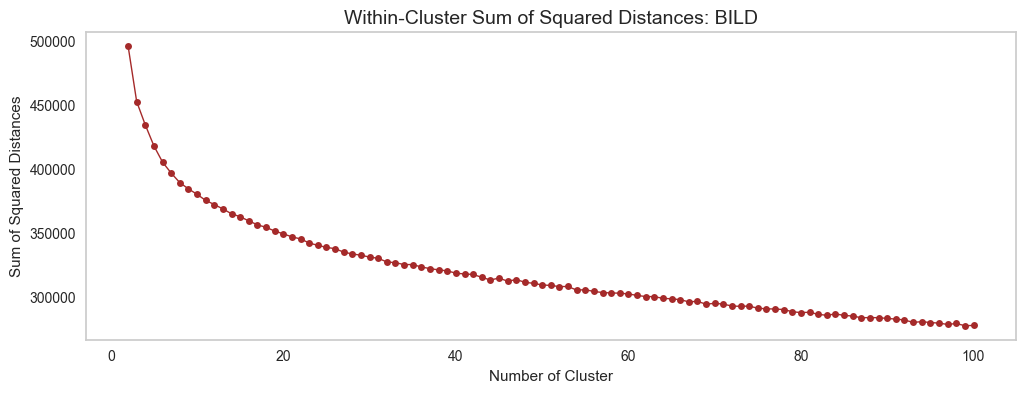

In [15]:
plot_ssd(x=bild_emb, k_lower_bound=K_LOWER_BOUND, k_upper_bound=K_UPPER_BOUND, label="BILD")

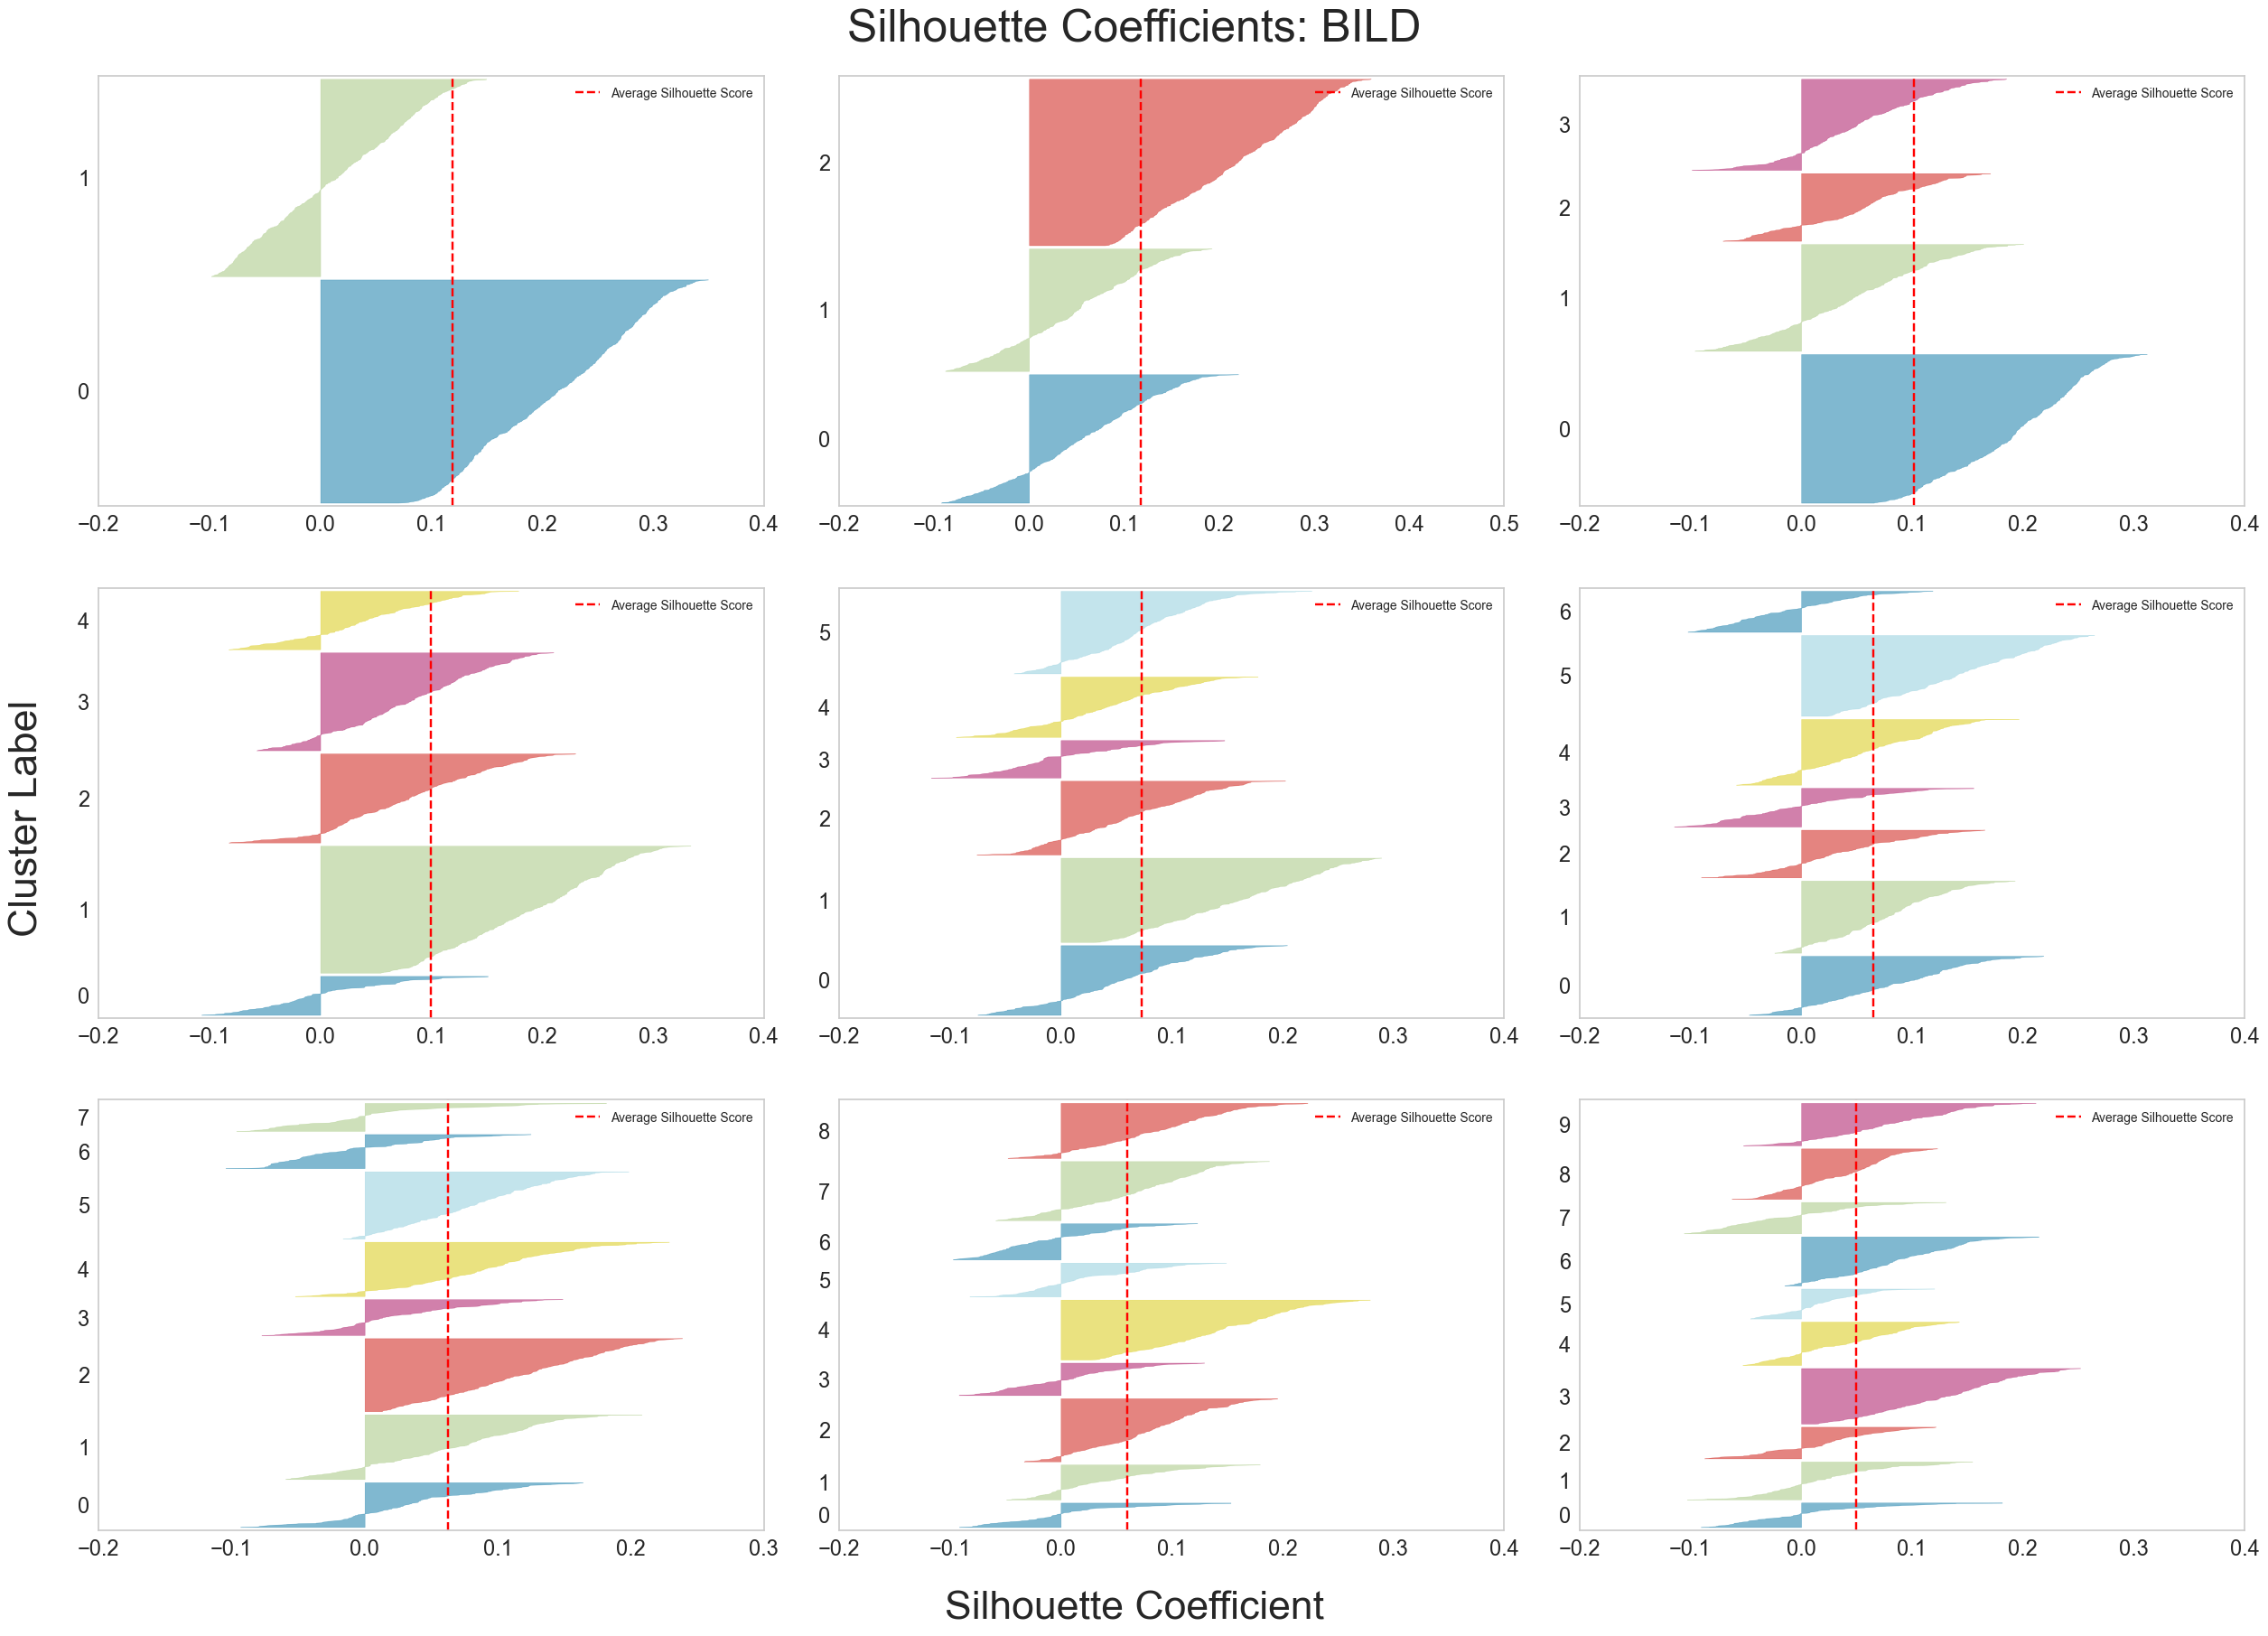

In [16]:
plot_silhouette_scores(x=bild_emb, k_lower_bound=2, k_upper_bound=10, label="BILD")

### FAZ:

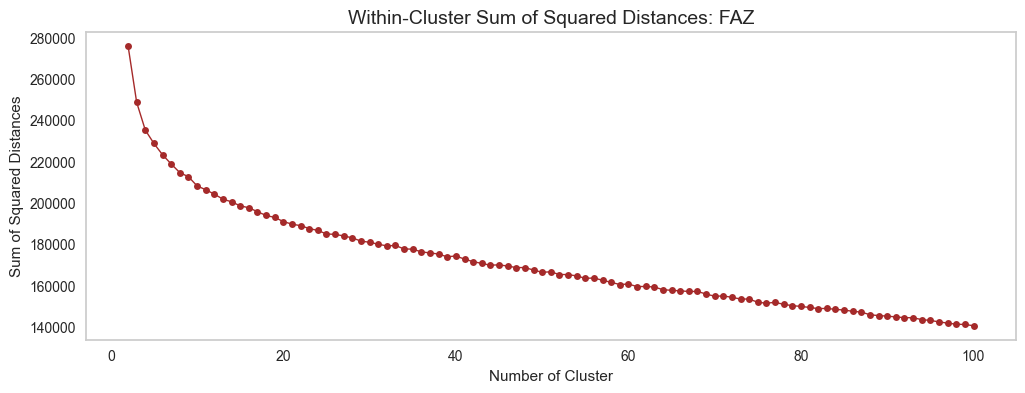

In [17]:
plot_ssd(x=faz_emb, k_lower_bound=K_LOWER_BOUND, k_upper_bound=K_UPPER_BOUND, label="FAZ")

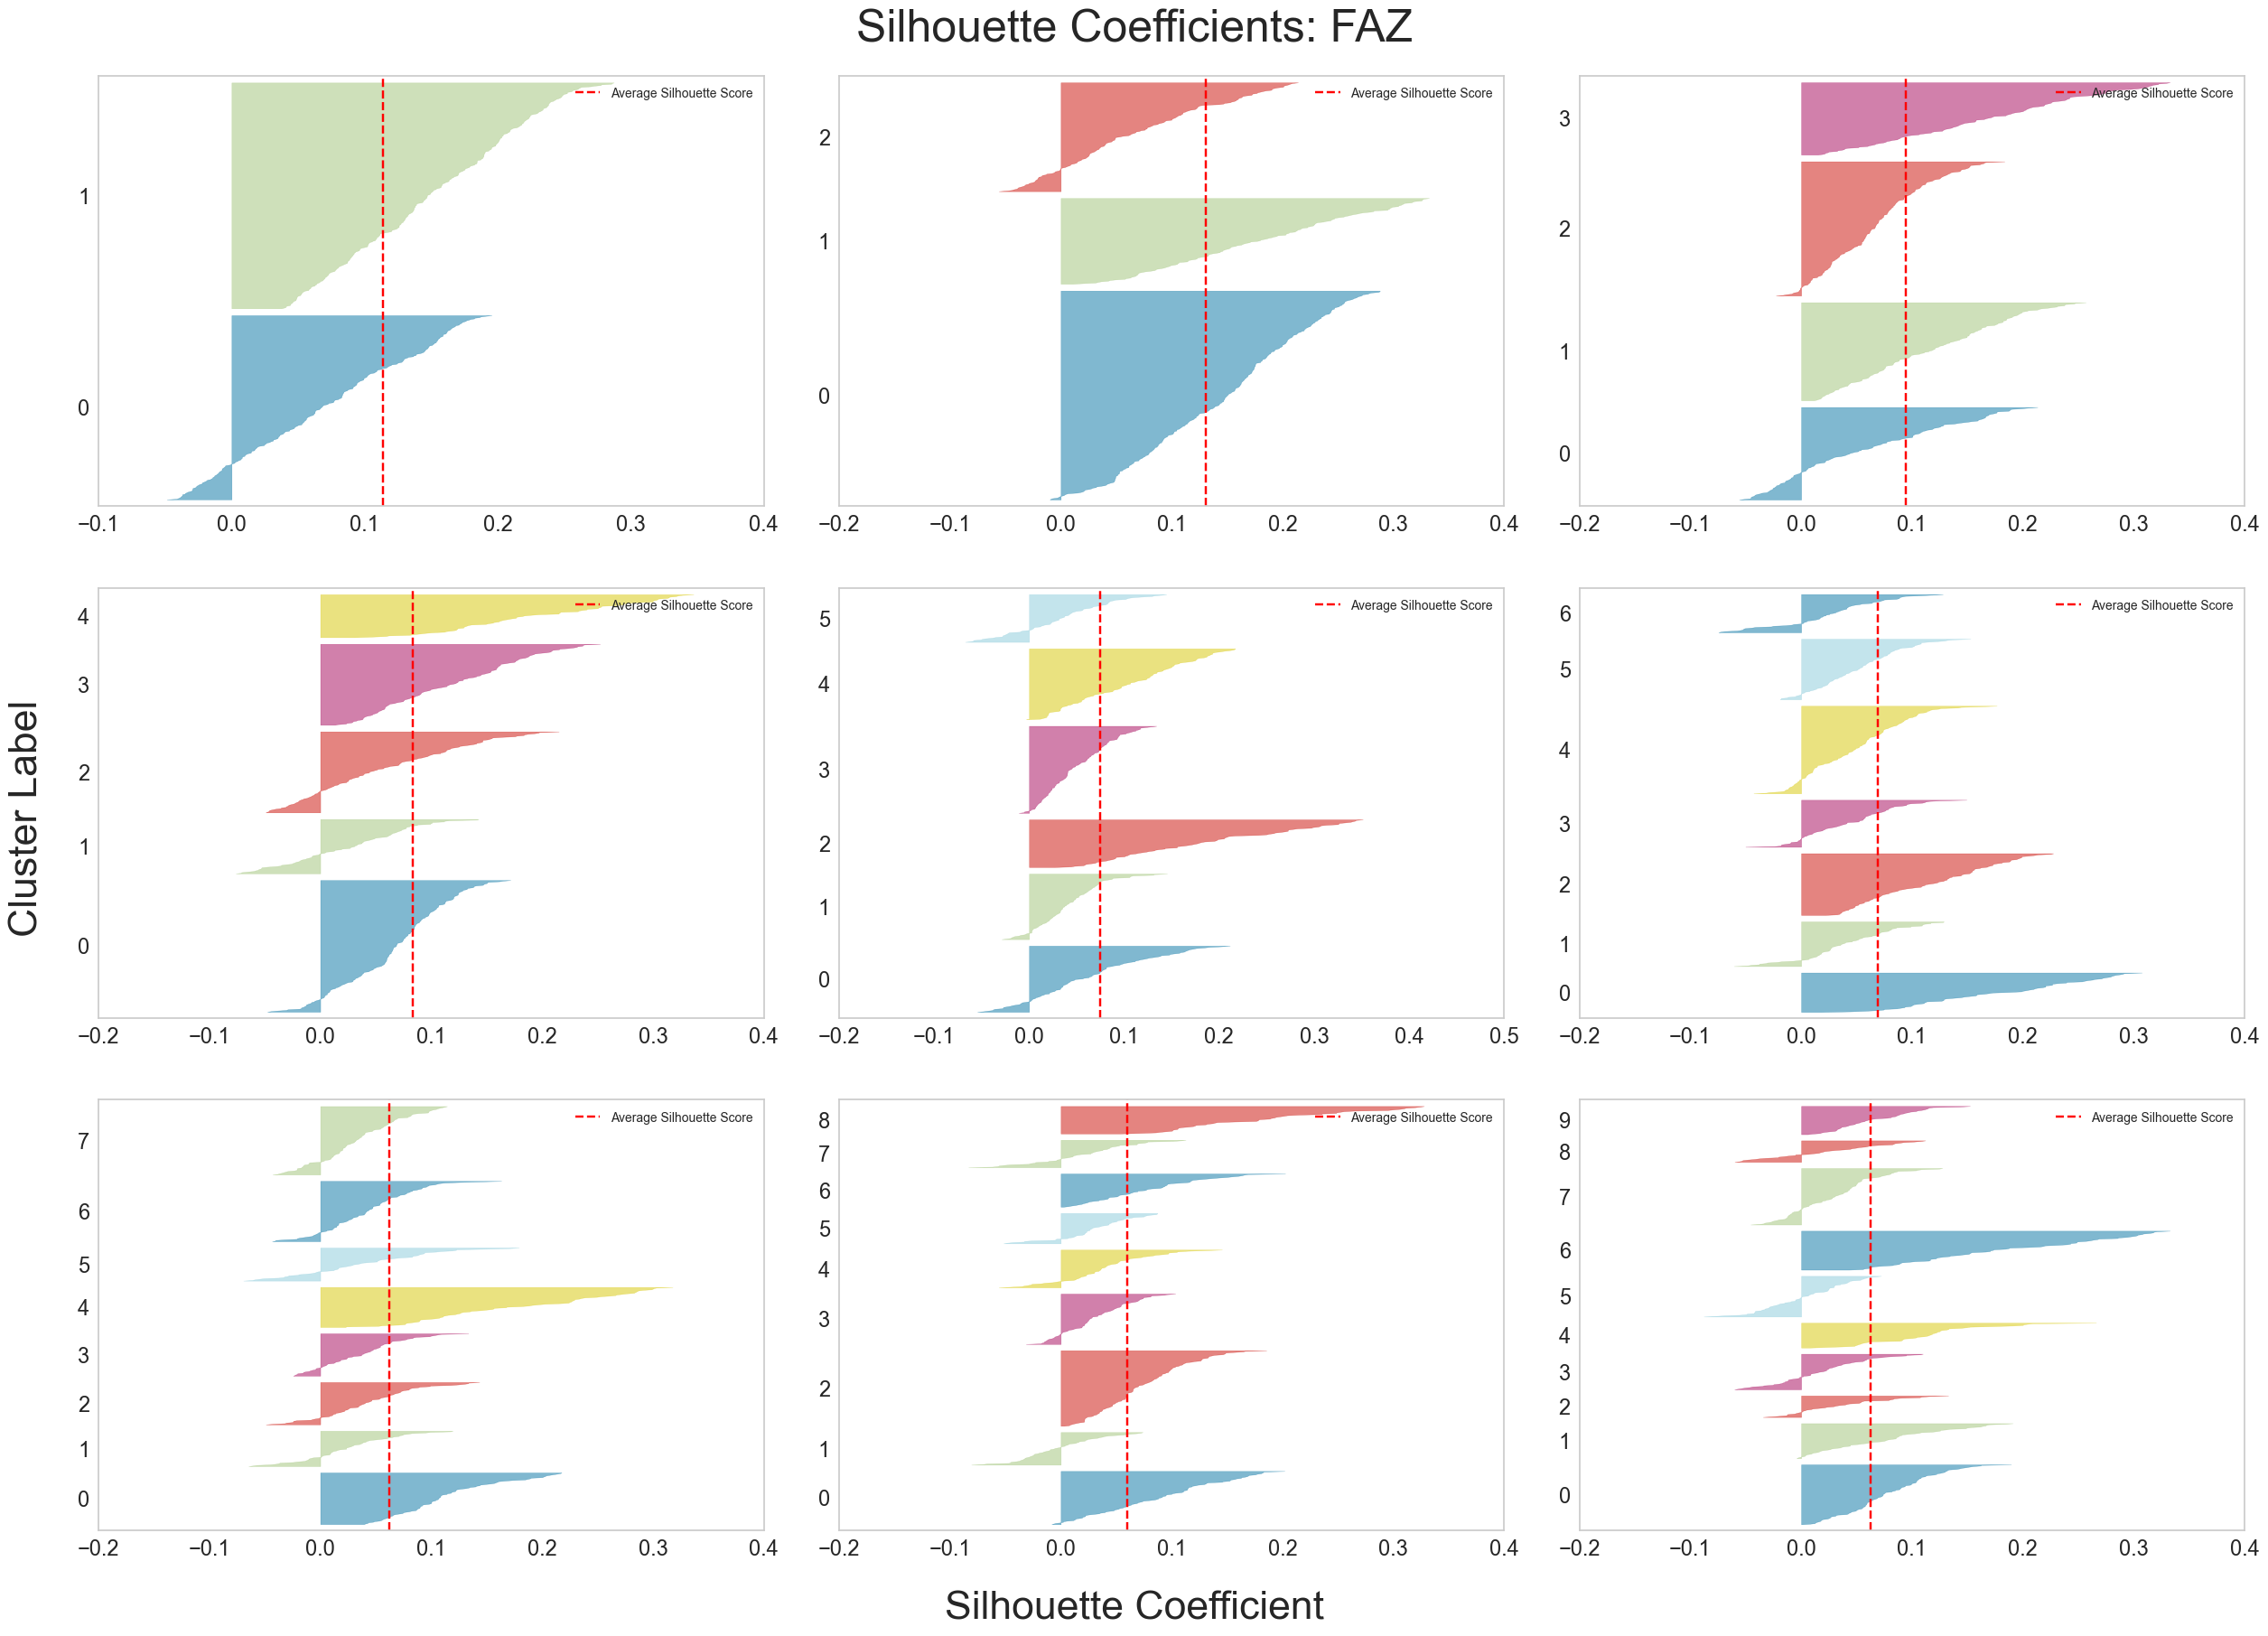

In [18]:
plot_silhouette_scores(x=faz_emb, k_lower_bound=2, k_upper_bound=10, label="FAZ")

### SZ:

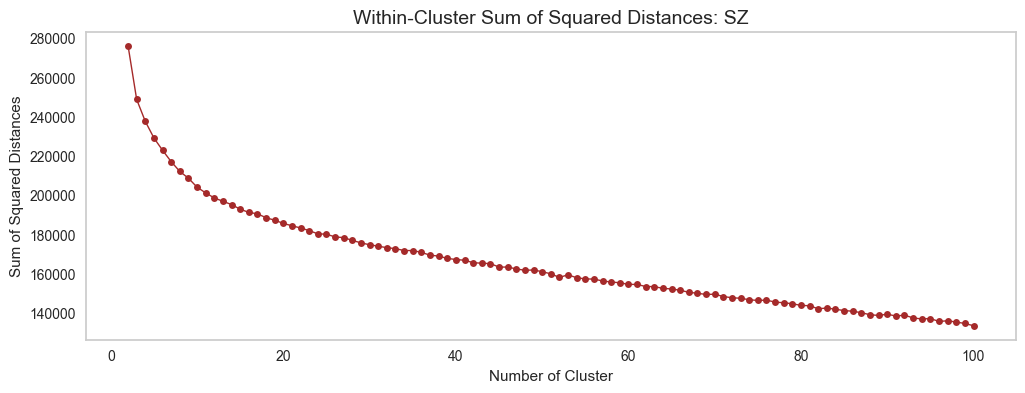

In [19]:
plot_ssd(x=sz_emb, k_lower_bound=K_LOWER_BOUND, k_upper_bound=K_UPPER_BOUND, label="SZ")

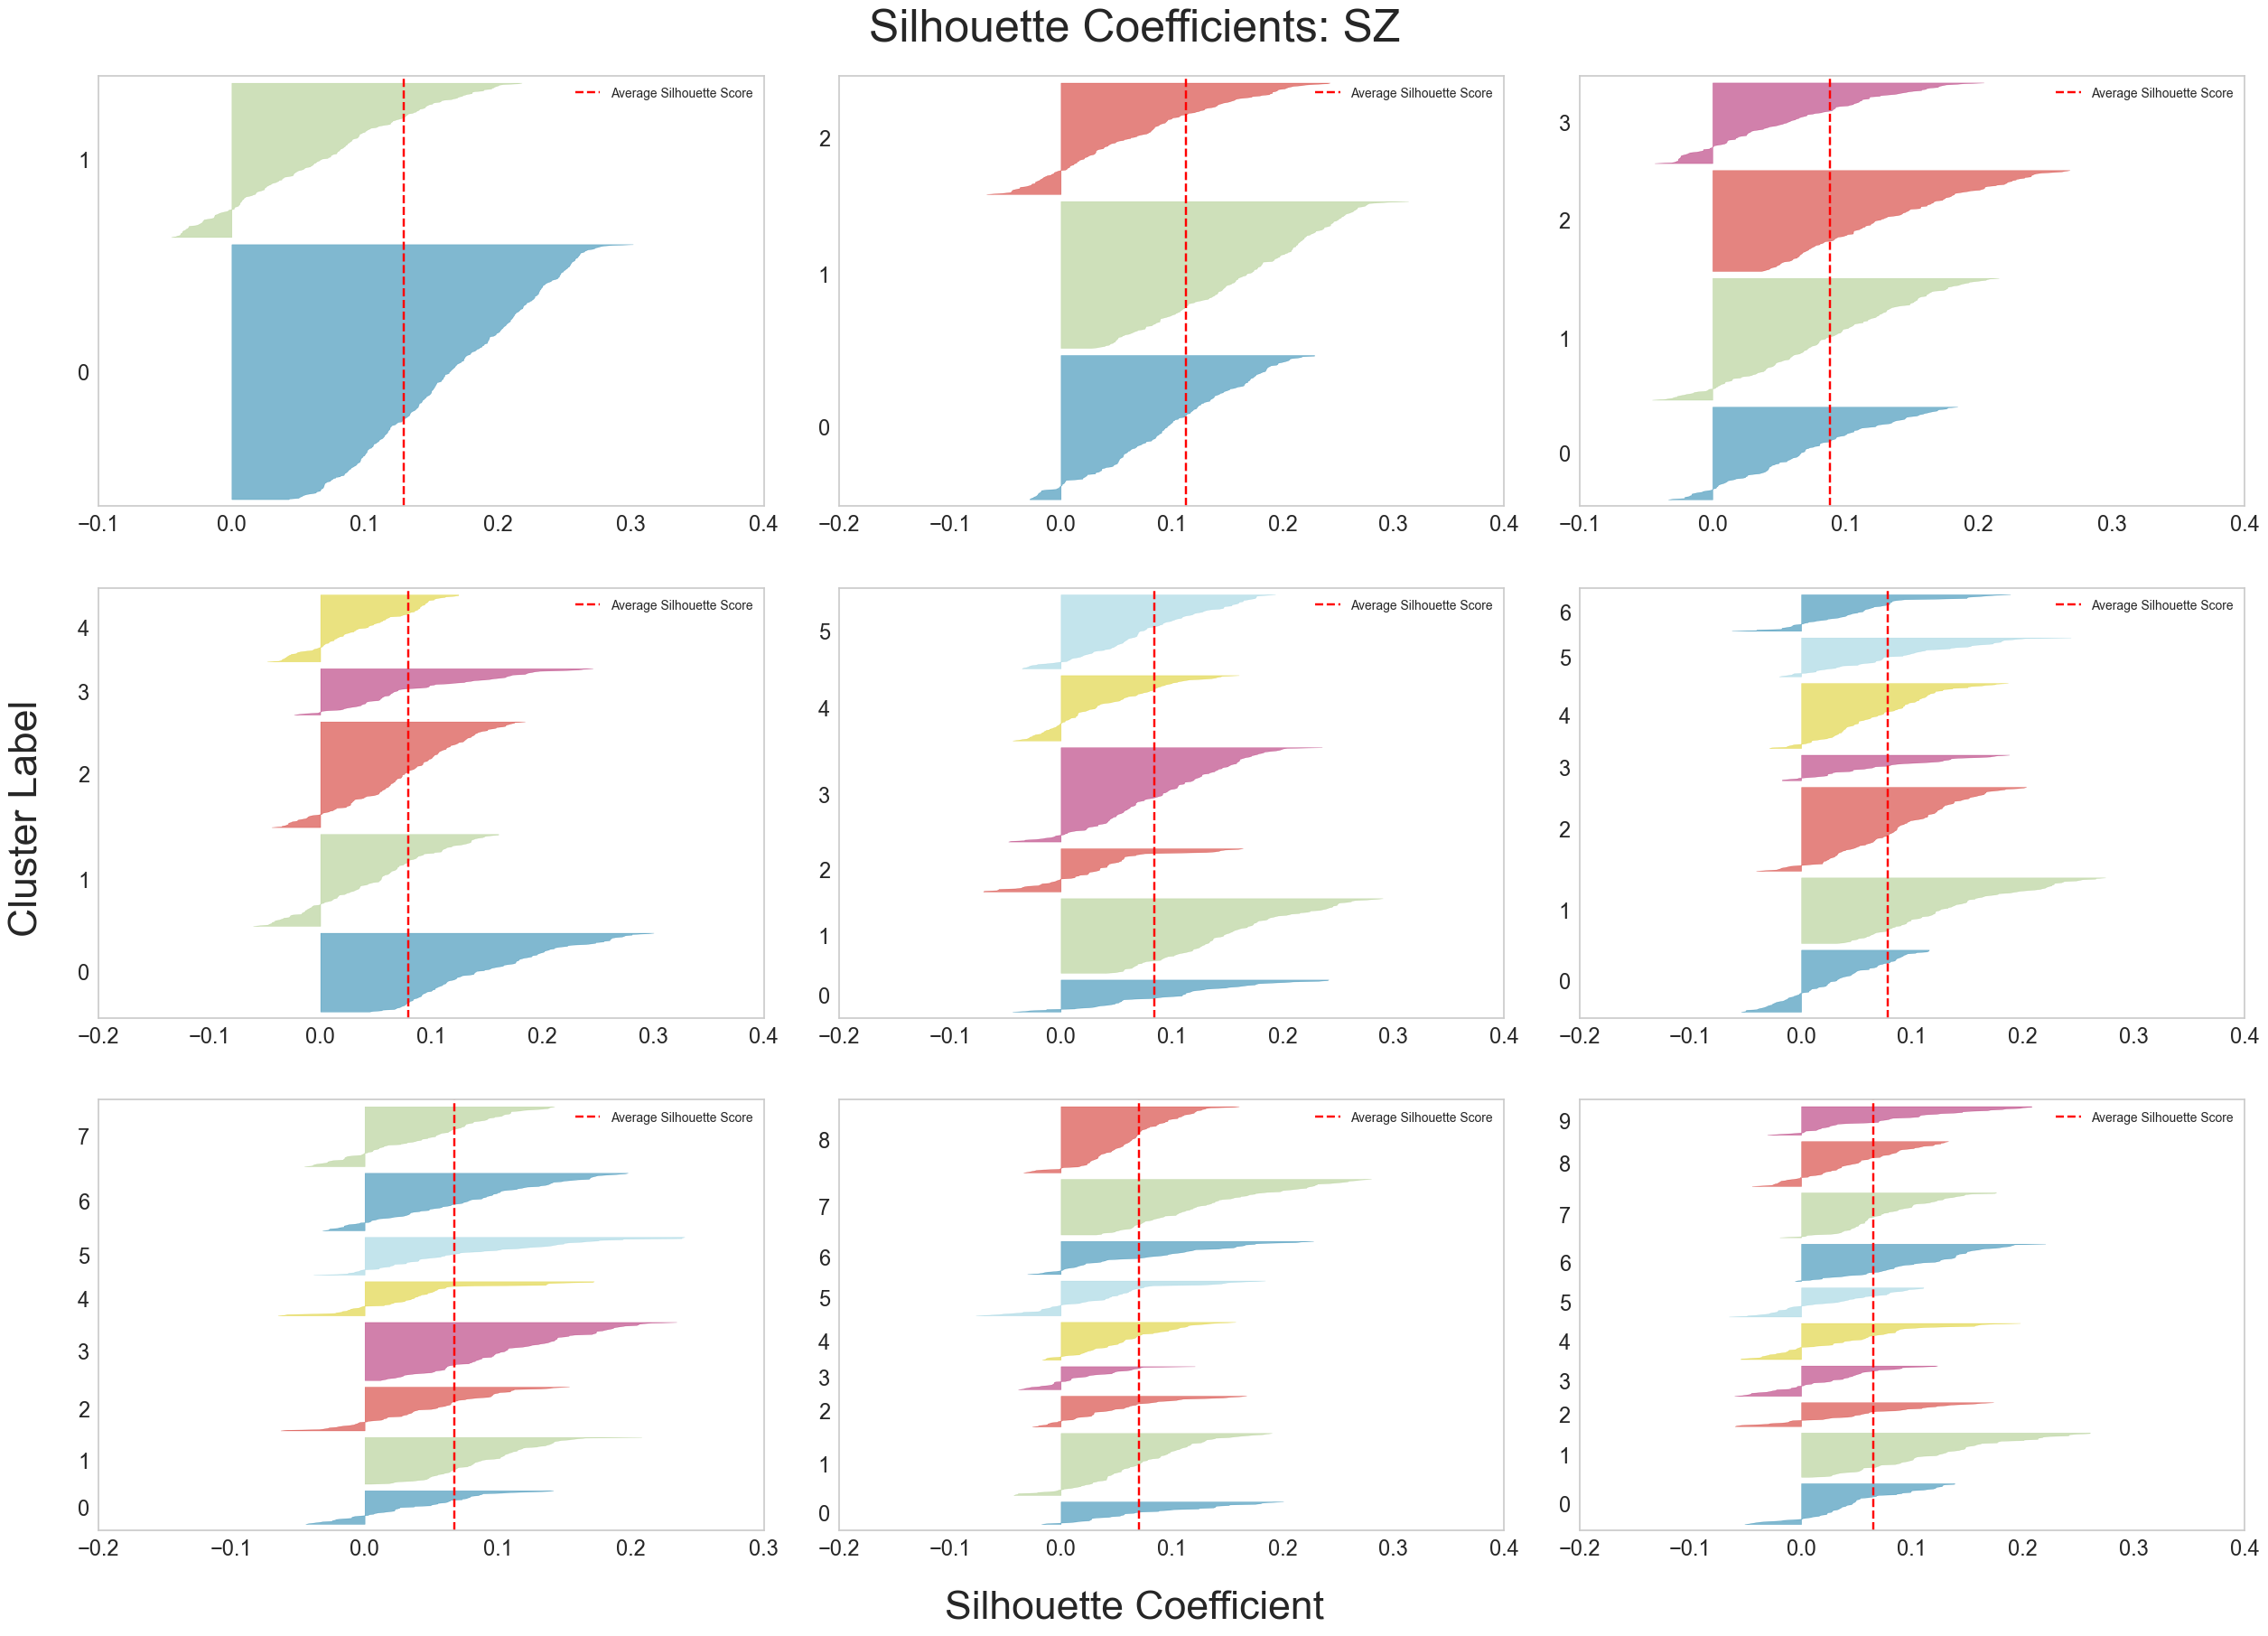

In [20]:
plot_silhouette_scores(x=sz_emb, k_lower_bound=2, k_upper_bound=10, label="SZ")

## 2.2 Cluster iterAdv-sentences using the optimal cluster amount found

In [21]:
def get_cluster_result(df, label, n_clusters):
    embs = [i.cpu().numpy() for i in df.loc[df["label"]==label, "bert_emb"].values]
    km = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    km.fit(embs)
    clusters = km.labels_.tolist()
    cluster_centers = km.cluster_centers_
    
    df_cluster = pd.DataFrame({
        "text": df.loc[df["label"]==label, "text"], 
        "text_preprocessed_cleaned": df.loc[df["label"]==label, "text_preprocessed_cleaned"], 
        "bert_embedding": embs, 
        "cluster": clusters
    })
    
    all_cos_sim = []
    for idx, row in df_cluster.iterrows():
        cos_sim = cosine(np.array(row["bert_embedding"]), cluster_centers[row["cluster"]])
        all_cos_sim.append(cos_sim)
    df_cluster.insert(4, "cossim_to_centroid", all_cos_sim)
    
    return df_cluster

In [22]:
df_cluster_bild = get_cluster_result(df, label=0, n_clusters=3)
print(df_cluster_bild.shape)
print(df_cluster_bild["cluster"].value_counts())
df_cluster_bild.head()

(1400, 5)
cluster
2    558
0    431
1    411
Name: count, dtype: int64


,text,text_preprocessed_cleaned,bert_embedding,cluster,cossim_to_centroid
1,Der Direktor der EU-Grenzschutzagentur Frontex...,Direktor EU-Grenzschutzagentur Frontex Fabrice...,"[1.3864895, -2.1976194, -0.041649222, -0.00270...",1,0.378225
2,Nachdem die als Zeugen vernommenen Flüchtlinge...,Zeuge vernommen Flüchtling Widerspruch verstri...,"[-0.2558641, 0.17892346, -1.9409926, -2.076917...",0,0.294483
3,Am Sonntagnachmittag brach erneut eine Schläge...,Sonntagnachmittag Schlägerei ausbrechen,"[0.513273, -0.95220774, -1.480712, -0.75573283...",2,0.163321
4,Nach zwei Stunden kam es erneut zu einer handf...,Stunde handfest Streitigkeit Person Heimbewohn...,"[0.9459323, 0.60807043, -2.1117177, -0.73203, ...",2,0.135220
7,Das US-amerikanische Wirtschaftsmagazin platzi...,US-amerikanisch Wirtschaftsmagazin platzieren ...,"[0.45244735, -1.302996, -1.6427314, -0.7167192...",1,0.253758


In [23]:
df_cluster_faz = get_cluster_result(df, label=1, n_clusters=3)
print(df_cluster_faz.shape)
print(df_cluster_faz["cluster"].value_counts())
df_cluster_faz.head()

(652, 5)
cluster
0    337
2    176
1    139
Name: count, dtype: int64


,text,text_preprocessed_cleaned,bert_embedding,cluster,cossim_to_centroid
15,Weil weder Geruch noch Geschmack abstoßend sin...,Geruch Geschmack abstoßend Zuwanderer gegessen,"[-0.062432777, -1.4380468, -1.9105431, -1.2804...",0,0.323448
25,"Dieser stelle immer wieder "" Dinge in den Raum...",stellen Ding Raum stimmen,"[0.903926, 0.94200367, -2.0886428, -2.0263493,...",0,0.109007
29,Seit Dezember wurden mehr als 3000 Dissidenten...,Dezember Dissident meist Stunde verhaften brut...,"[-0.14014977, -1.5463411, -2.5964153, -0.72266...",2,0.215924
44,Der neue italienische Außenminister Enzo Moave...,neu italienisch Außenminister Enzo Moavero Mil...,"[1.5008786, -2.0248687, -0.96835315, 0.0357073...",2,0.634653
45,"Ein kurzes Zeitfenster nur , in dem Deutschlan...",kurz Zeitfenster Deutschland freundlich Gesich...,"[0.10647044, -0.256285, -1.321668, -1.2174616,...",2,0.205369


In [24]:
df_cluster_sz = get_cluster_result(df, label=2, n_clusters=3)
print(df_cluster_sz.shape)
print(df_cluster_sz["cluster"].value_counts())
df_cluster_sz.head()

(628, 5)
cluster
1    229
0    225
2    174
Name: count, dtype: int64


,text,text_preprocessed_cleaned,bert_embedding,cluster,cossim_to_centroid
0,Bislang hatten die Innenminister immer wieder ...,Innenminister bestimmt Stichtag Bleiberecht ge...,"[0.52933, 0.29947704, -1.7623825, -1.7229828, ...",0,0.145678
5,Dann war schon wieder Schluss mit der angekünd...,Schluss angekündigt groß Umverteilung,"[1.2716942, 0.22691007, -1.6316874, -1.1650274...",0,0.181813
6,Nun stellt sich erneut die Frage der Lastentei...,stellen Frage Lastenteilung Gesetz Land Kommun...,"[-0.19793661, -2.087709, -2.036945, -1.8740518...",1,0.225380
12,"Der Anschlag vom Mittwoch sei Anlass , "" noch ...",Anschlag Mittwoch Anlass genau hinzuschauen Si...,"[1.3235742, -1.0319859, -0.7402194, -2.1881754...",0,0.391388
14,Dass das Bistum das Pfarrheim schließlich räum...,Bistum Pfarrheim räumen lassen CSU-Generalsekr...,"[1.0616555, -0.42474946, -1.5080007, -1.730183...",0,0.357062


# 3. Extract keywords

In [25]:
def get_token_cluster_mapping(df):
    all_clusters = []
    all_tokens = []
    
    for idx, row in df.iterrows():
        for token in row["text_preprocessed_cleaned"].split():
            all_clusters.append(row["cluster"])
            all_tokens.append(token)
                
                
    df_token_cluster_mapping = pd.DataFrame({
        "cluster": all_clusters,
        "token": all_tokens
    })
    
    return df_token_cluster_mapping

In [26]:
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    df['pmi_freq'] = np.log(df["f_y"]) * np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) ) 
    
    return df

In [27]:
def get_keywords(df_cluster_results, top_n, label):
    clusters = sorted(df_cluster_results["cluster"].unique())
    
    df_tokens = get_token_cluster_mapping(df_cluster_results)
    df_pmi_all = pmi(df_tokens, "cluster", "token")
    
    fig, ax = plt.subplots(figsize=(12, 36))
    colors = plt.cm.tab20b(np.linspace(0, 1, len(clusters))) # Set colors for each cluster
    
    all_topn_items = []
    all_cluster_labels = []

    # Variables to make the legends show in the order of (0, 1, 2) instead of (2, 1, 0)
    legend_handles = [] 
    legend_labels = []  
    
    for i, c in enumerate(clusters[::-1]): 
        df_pmi = df_pmi_all[df_pmi_all["cluster"] == c].drop_duplicates().sort_values(by='pmi_freq', ascending=False)
        
        top_n_val = set()
        for idx, row in df_pmi.iterrows():
            top_n_val.add(row["pmi_freq"])
            if len(top_n_val) > top_n - 1:
                break
        
        df_pmi_topn = df_pmi[df_pmi["pmi_freq"] >= min(top_n_val)].groupby('pmi_freq')['token'].apply(list)
        all_topn_items.append(df_pmi_topn)
        all_cluster_labels += [c] * df_pmi_topn.shape[0]
        
        tokens_groupped = [', '.join(items) for items in df_pmi_topn]
        tokens_groupped_wrapped = [textwrap.fill(tokens, width=80) for tokens in tokens_groupped]
        bar = ax.barh(tokens_groupped_wrapped, df_pmi_topn.index, color=colors[i], height=0.6, label=f'Cluster {c}')
        
        legend_handles.append(bar)
        legend_labels.append(f'Cluster {c+1}')

    ax.grid(False)
    ax.set_xlabel('PMI-freq', fontsize=28) 
    ax.set_title('Top Keywords by Cluster: ' + label, fontsize=32)
    ax.legend(reversed(legend_handles), reversed(legend_labels), fontsize=26)    
    
    plt.xticks(fontsize=28) 
    plt.yticks(fontsize=28) 
    plt.savefig("./output/plots/cluster_keywords_" + label.lower() + ".pdf", bbox_inches="tight")
    
    df_all_topn_items = pd.DataFrame(pd.concat(all_topn_items, axis=0, ignore_index=True))
    df_all_topn_items.insert(1, "cluster", all_cluster_labels)

    return df_all_topn_items

## BILD:

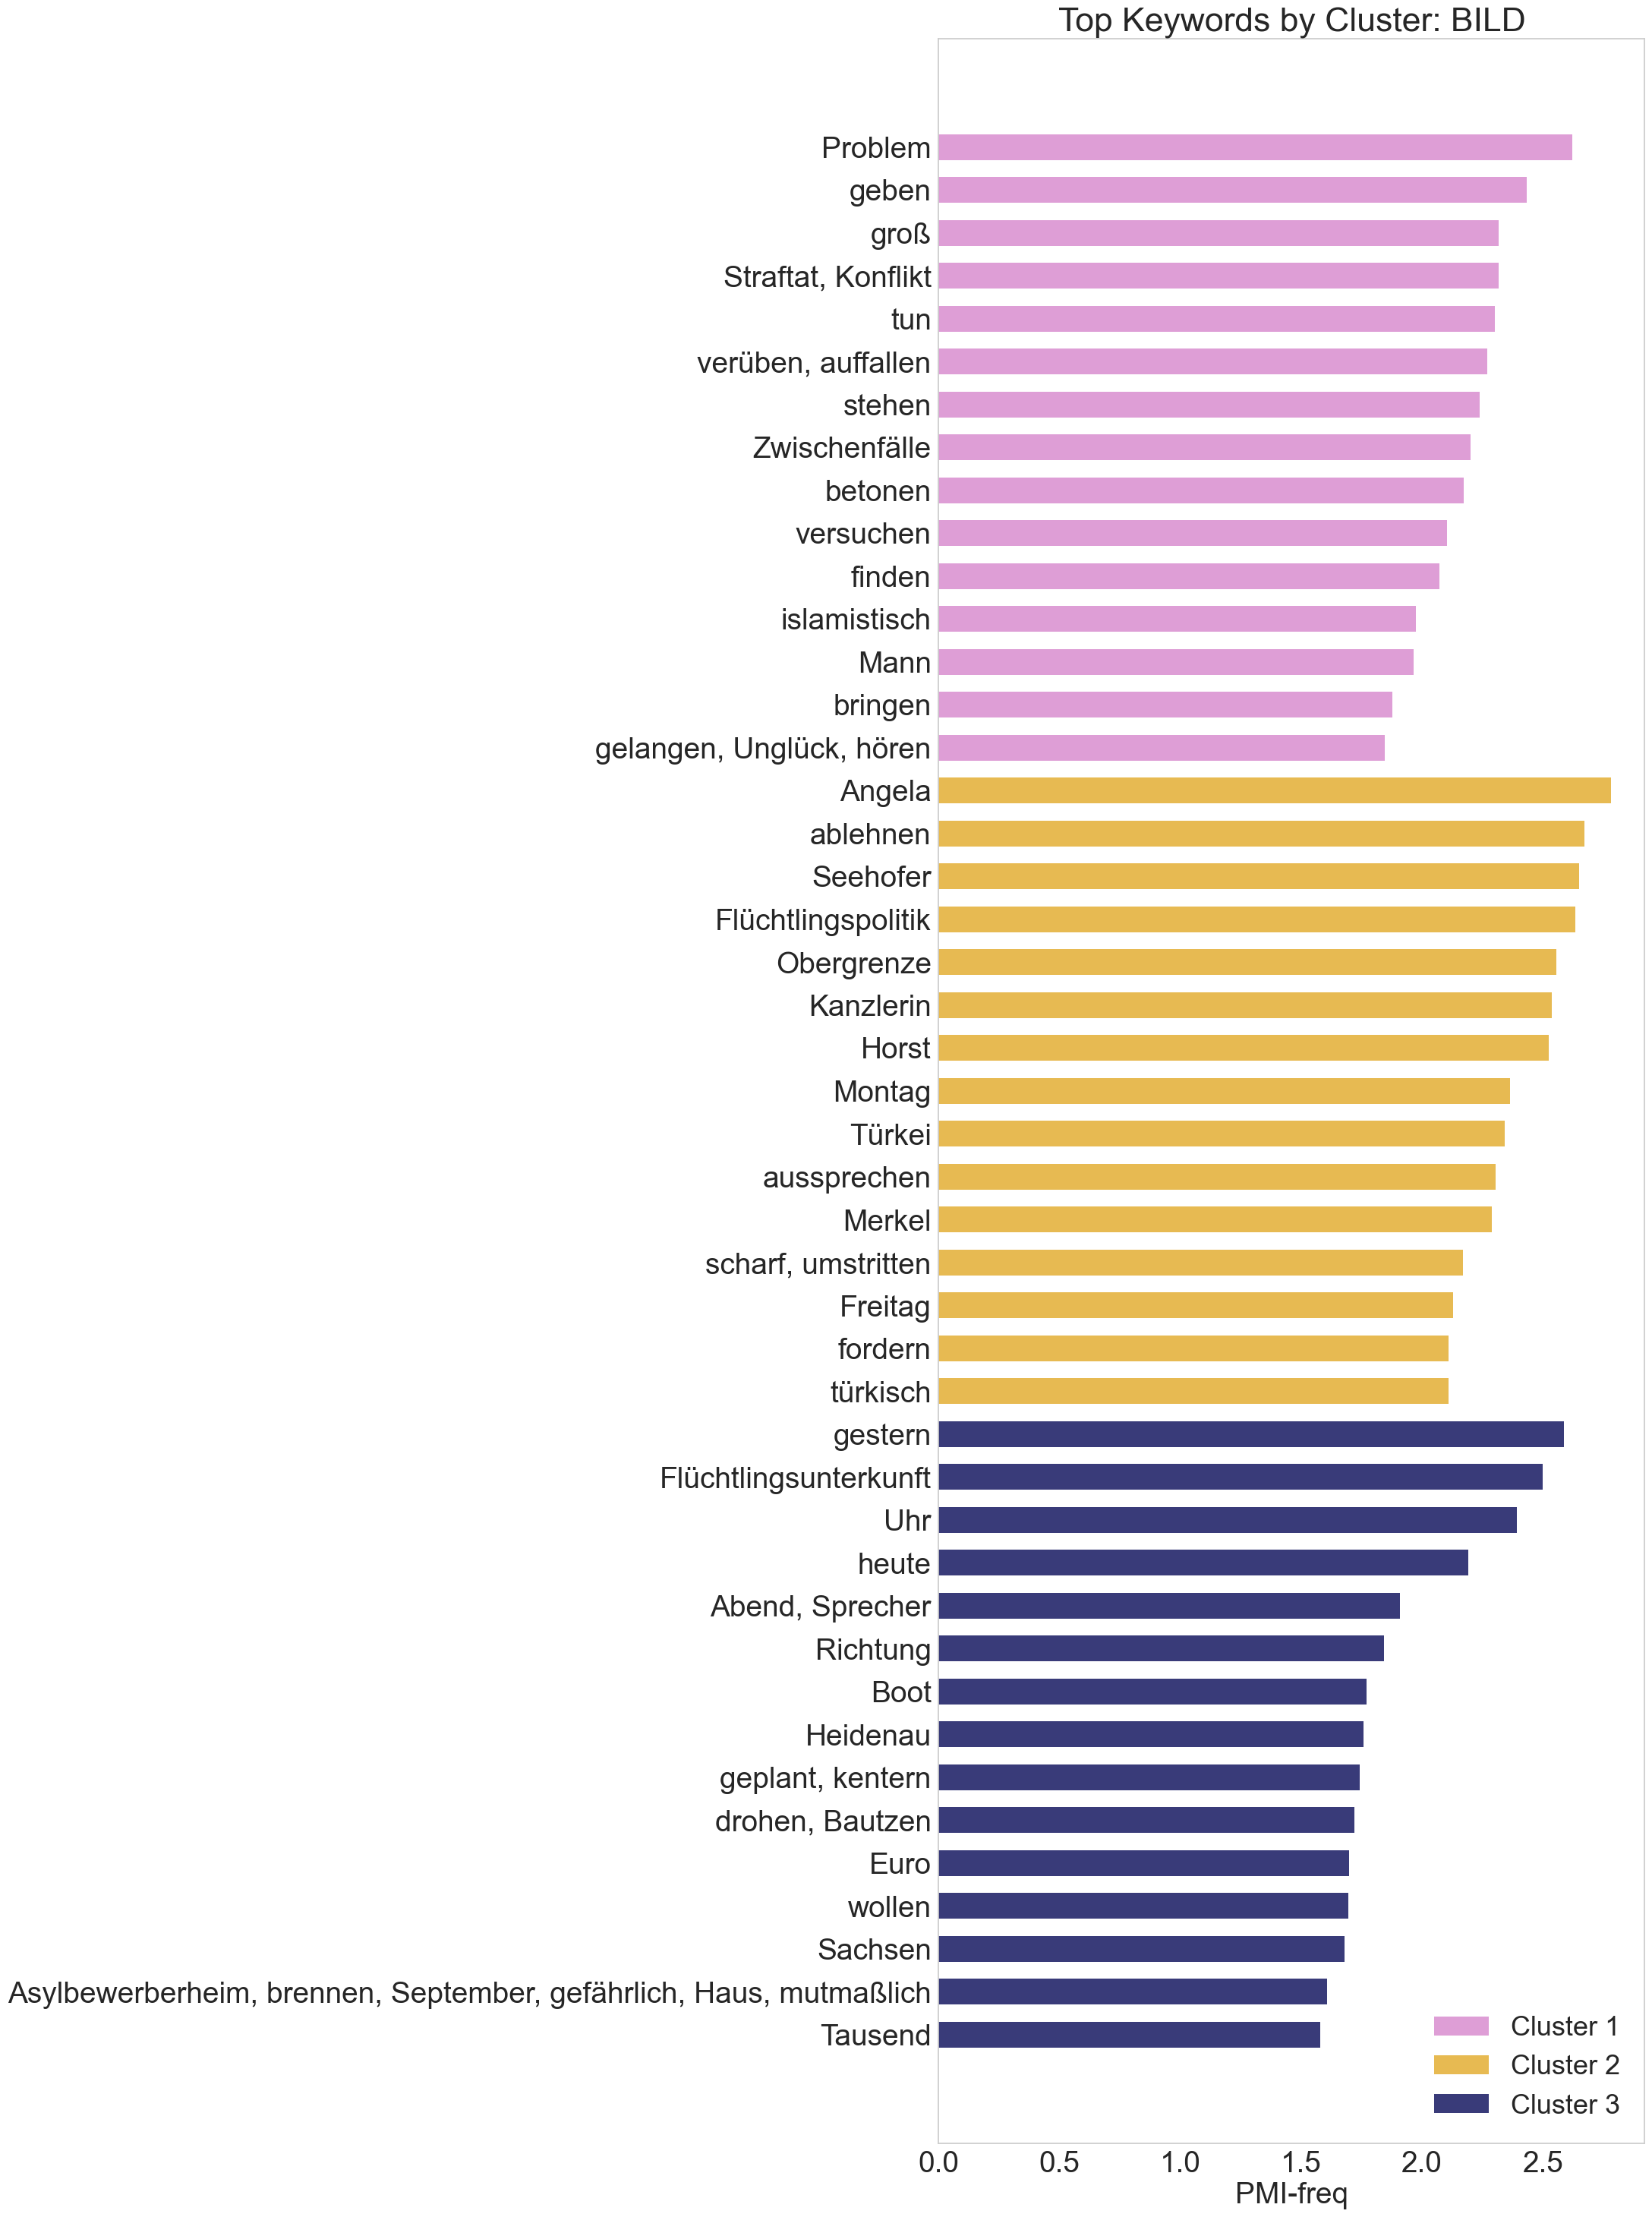

In [28]:
df_bild_keywords = get_keywords(df_cluster_results=df_cluster_bild, top_n=15, label="BILD")

## FAZ:

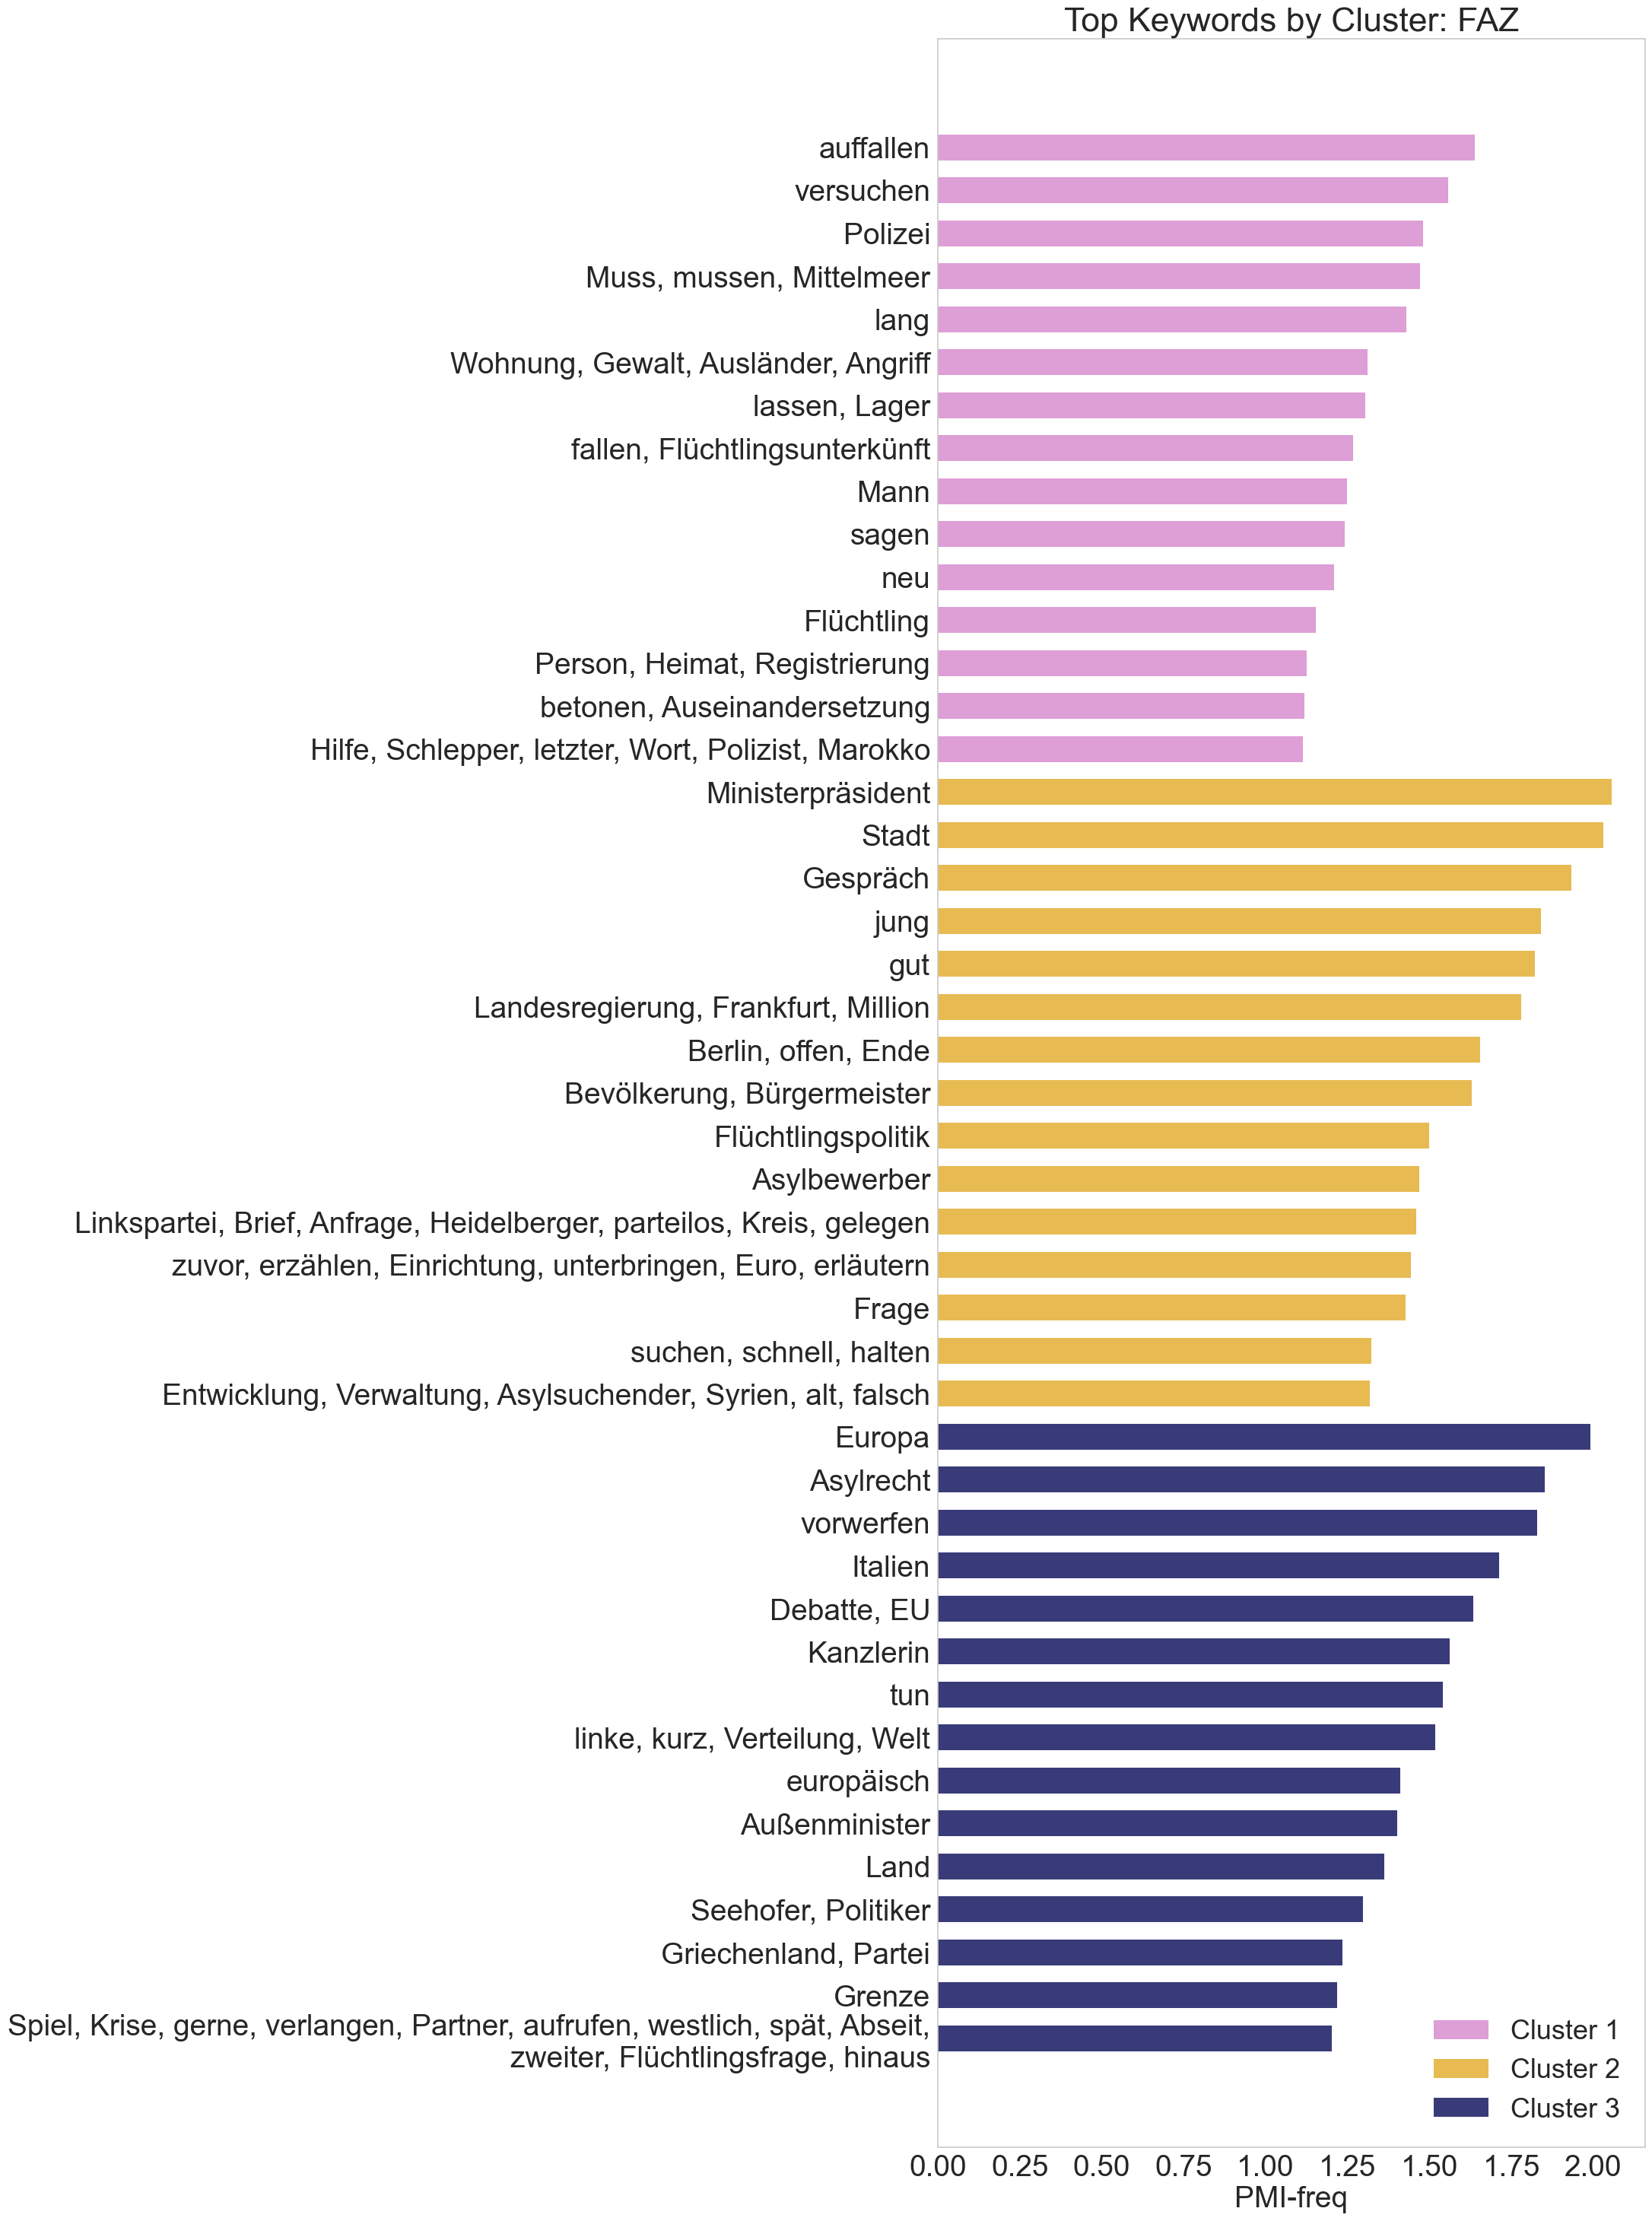

In [29]:
df_faz_keywords = get_keywords(df_cluster_results=df_cluster_faz, top_n=15, label="FAZ")

## SZ:

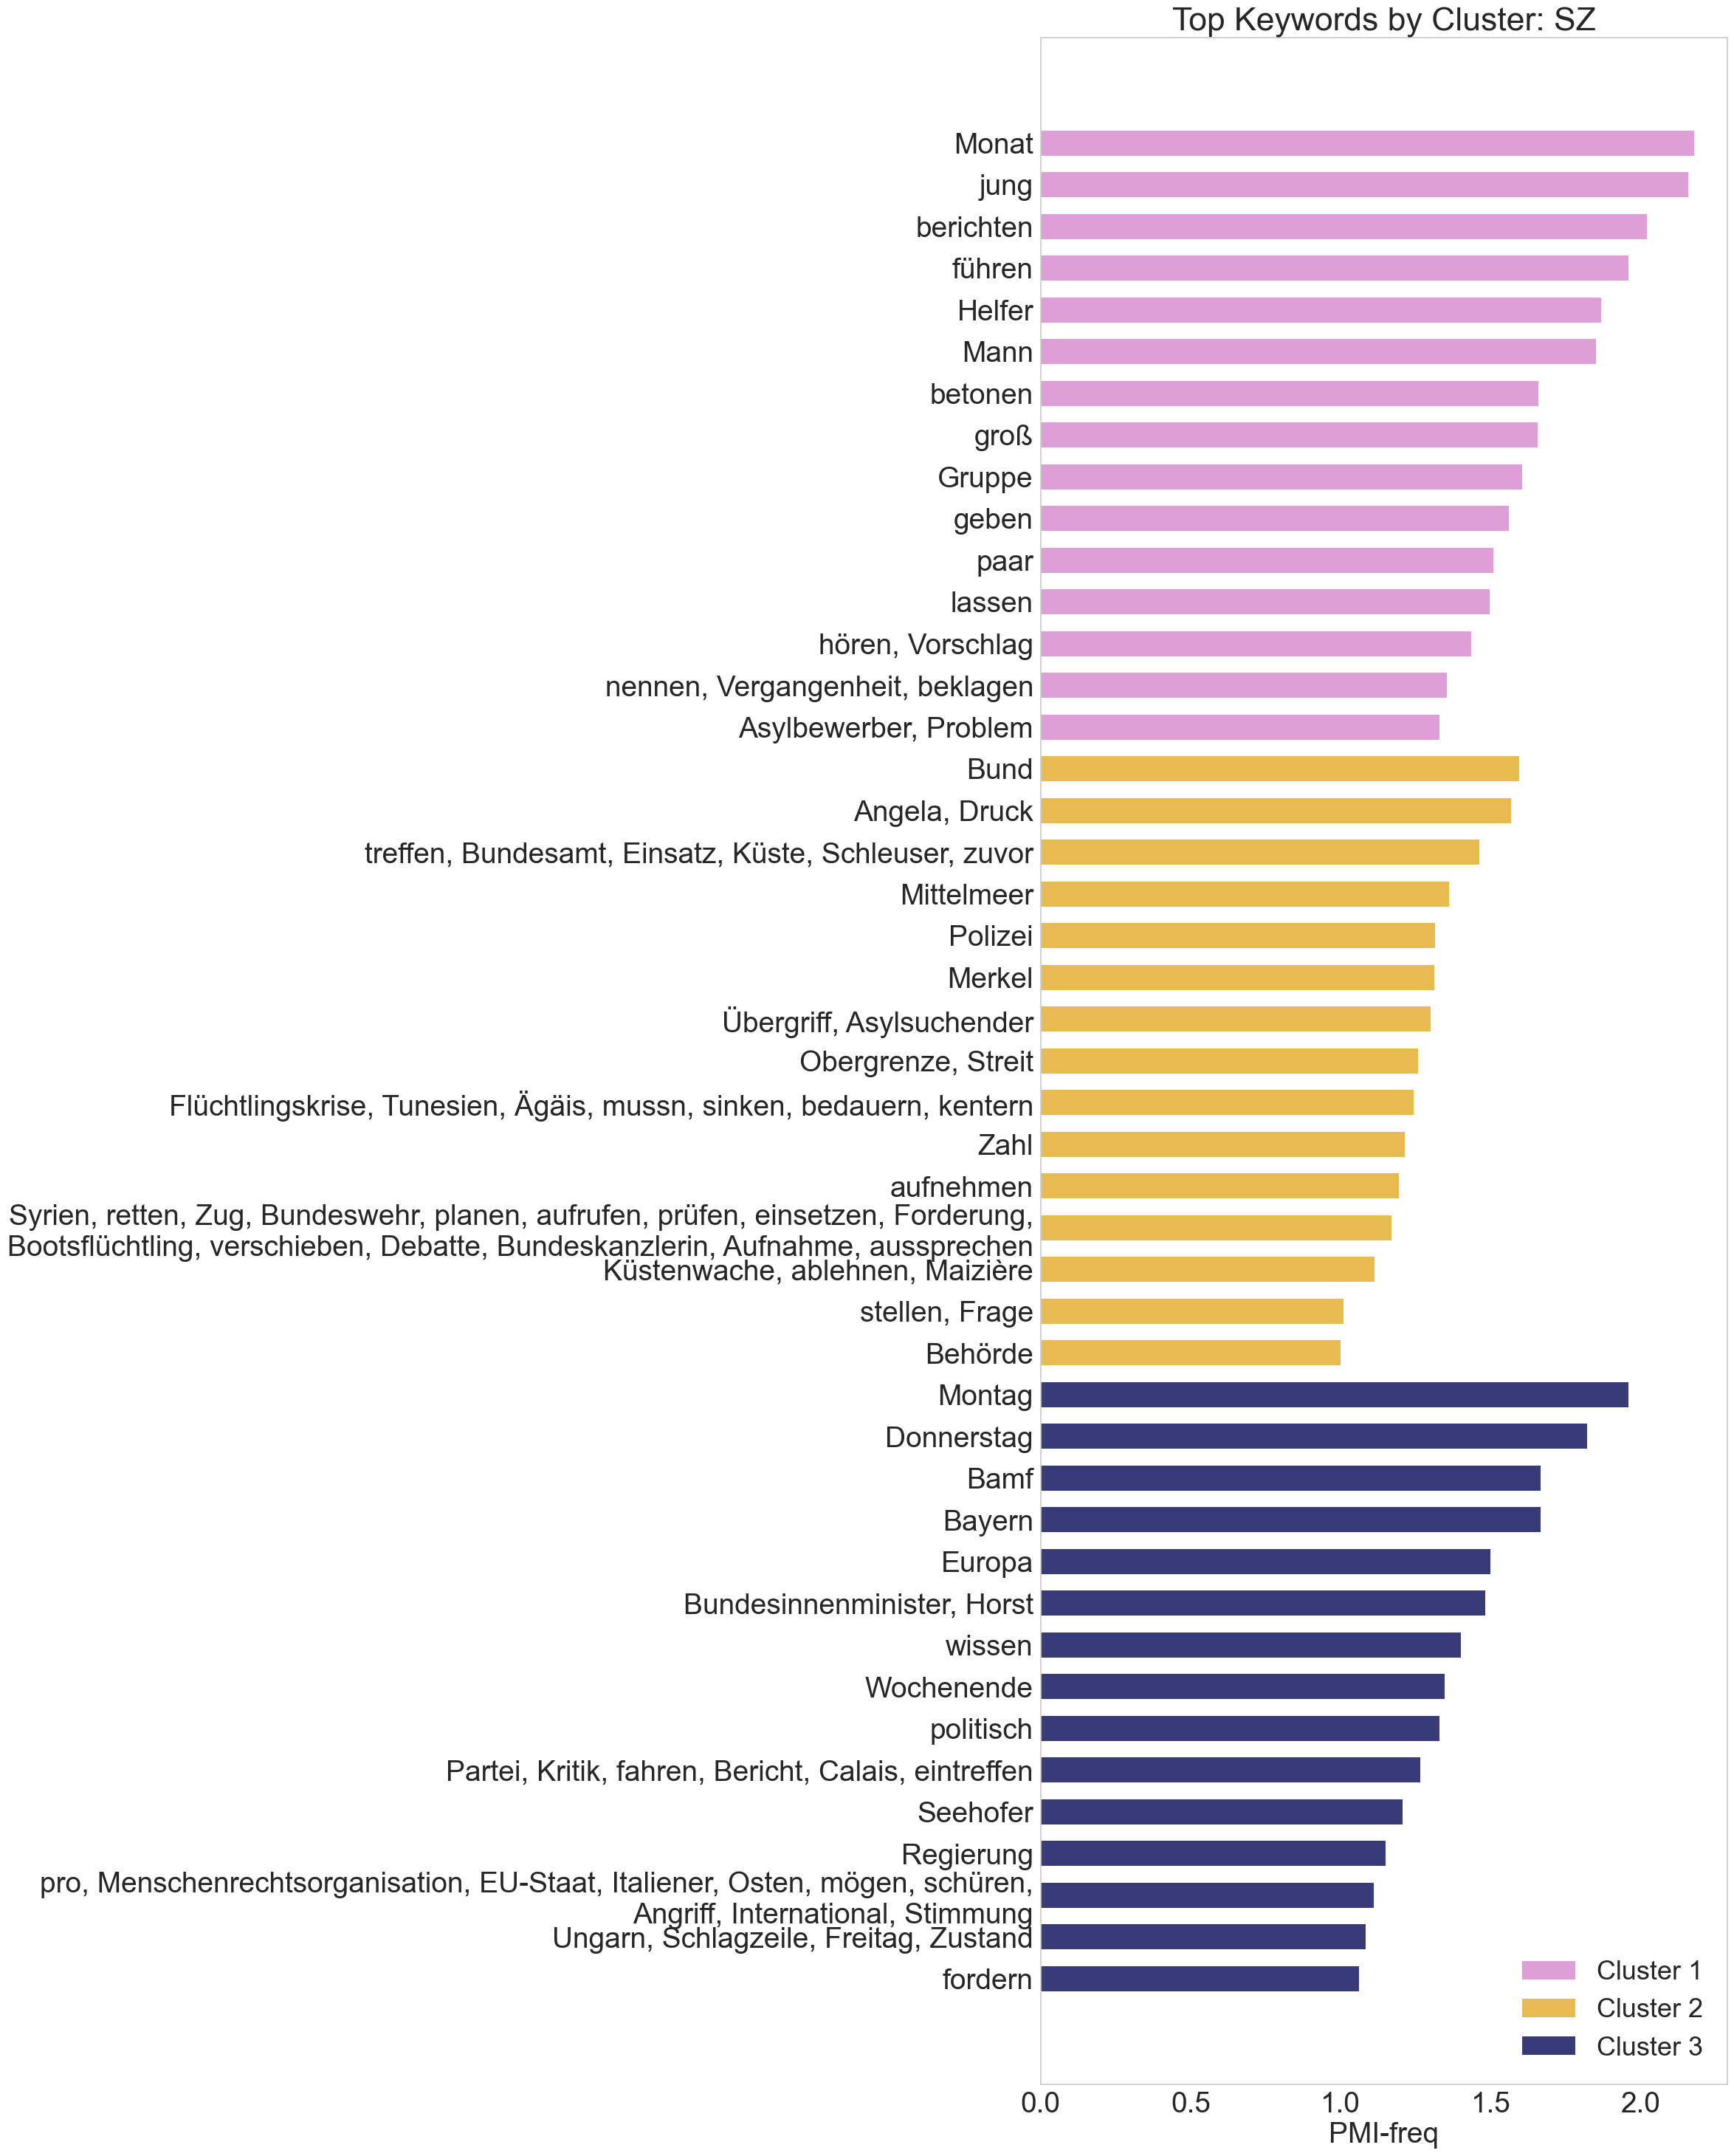

In [30]:
df_sz_keywords = get_keywords(df_cluster_results=df_cluster_sz, top_n=15,label="SZ")

# 4. Map keywords to RMFV

In [31]:
rmfv_dict = defaultdict(list)

for filename in os.listdir("../data/rmfv"):
    if filename.endswith(".txt"):
        current_topic = filename.split(".")[0]

        with open(os.path.join("../data/rmfv", filename)) as f:
            for line in f.readlines():
                if line.startswith("#") is False:
                    rmfv_dict[line.strip()].append(current_topic)

In [32]:
def get_rmfv_mapping_of_keywords(embedding_model_path, cluster_keywords):
    word2vec_model = KeyedVectors.load(embedding_model_path)
    vocab = word2vec_model.wv.key_to_index
    
    all_max_similarity_items = []
    all_max_similarity_values = []
    all_topics = []
    
    for cluster_keyword in cluster_keywords:
        max_similarity_value = 0
    
        for rmfv_keyword in rmfv_dict.keys():
            if cluster_keyword in vocab and rmfv_keyword in vocab:
                current_sim = word2vec_model.wv.similarity(cluster_keyword, rmfv_keyword)
                if current_sim > max_similarity_value:
                    max_similarity_value = current_sim
                    
        max_similarity_items = []
        topics = []
        for rmfv_keyword in rmfv_dict.keys():
            if cluster_keyword in vocab \
            and rmfv_keyword in vocab \
            and word2vec_model.wv.similarity(cluster_keyword, rmfv_keyword) == max_similarity_value:
                max_similarity_items.append(rmfv_keyword)
                for topic in rmfv_dict[rmfv_keyword]:
                    topics.append(topic)
                
                
        all_max_similarity_items.append(max_similarity_items)
        all_max_similarity_values.append(max_similarity_value)
        all_topics.append(topics)

    df_most_similar = pd.DataFrame({
        "cluster_keyword": cluster_keywords,
        "most_similar_rmfv_keyword": all_max_similarity_items,
        "topic": all_topics,
        "similarity": all_max_similarity_values
    })

    return df_most_similar

In [33]:
def plot_rmfv_mapping(df_most_similar_items, label):
    topic_counts = Counter([t for topics in df_most_similar_items["topic"] for t in topics])
    topic_counts = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

    topics = [item[0] for item in topic_counts]
    frequencies = [item[1] for item in topic_counts]
    
    fig, ax1 = plt.subplots(figsize=(8, 2))
    
    # Plot frequency of RMFV-mapped topics: 
    ax1.bar(topics, frequencies, color='brown') 
    ax1.set_ylabel('Mapping Frequency', fontsize=12)
    ax1.set_title('Topic Mapping of Extracted Keywords: ' + label, fontsize=14)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)  
    ax1.tick_params(axis='y', labelsize=12) 
    ax1.grid(False)
    
    # Plot RMFV vocabulary size for each topic:
    rmfv_counts = Counter([t for topics in rmfv_dict.values() for t in topics])
        
    ax2 = ax1.twinx()
    ax2.plot(topics, [rmfv_counts[topic] for topic in topics], color='goldenrod', marker='o') 
    ax2.set_ylabel('Vocabulary Size in RMFV', fontsize=12)
    ax2.tick_params(axis='y', labelsize=12)  
    ax2.grid(False)
    
    plt.savefig("./output/plots/cluster_keywords_rmfv_mapping_" + re.sub("[\W\s]+", "_", label).lower() + ".pdf", bbox_inches="tight")

In [34]:
word2vec_model_paths = {
    "BILD": "../output/word2vec/BILD_300d_allyears.model",
    "FAZ": "../output/word2vec/FAZ_300d_allyears.model",
    "SZ": "../output/word2vec/SZ_300d_allyears.model"
}

## BILD:

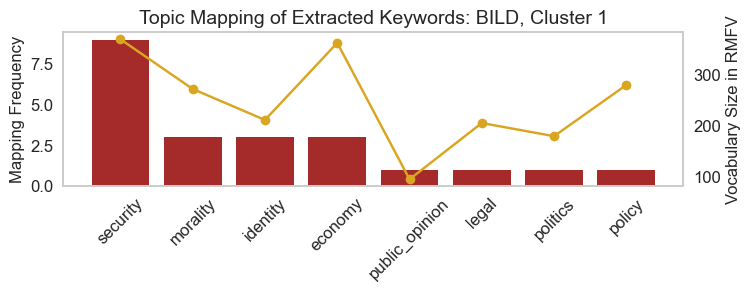

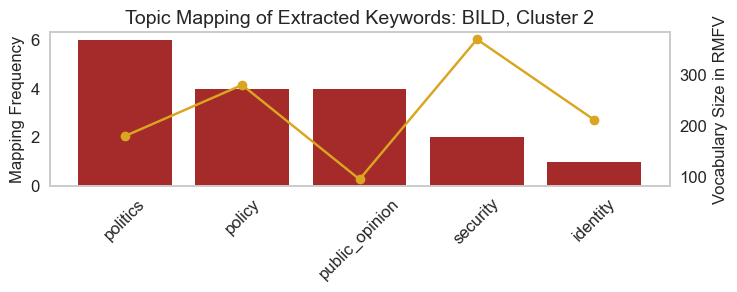

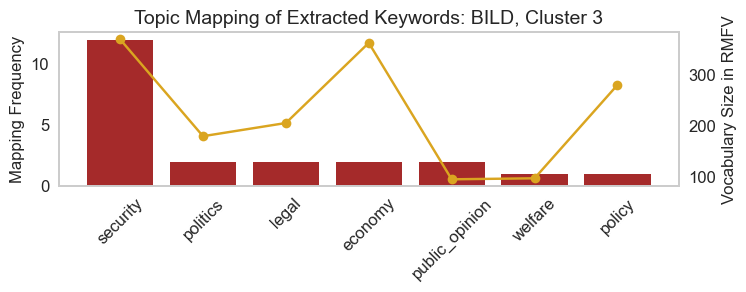

In [35]:
df_mapping_bild = []
all_cluster_labels = []

for i in range(0, 3):
    all_cluster_keywords_bild = [word for item in df_bild_keywords[df_bild_keywords["cluster"] == i]["token"] for word in item]
    df_most_similar_bild = get_rmfv_mapping_of_keywords(word2vec_model_paths["BILD"], all_cluster_keywords_bild)
    df_mapping_bild.append(df_most_similar_bild)
    all_cluster_labels += [i] * len(all_cluster_keywords_bild)
    plot_rmfv_mapping(df_most_similar_items=df_most_similar_bild, label="BILD, Cluster " + str(i+1))

In [36]:
df_mapping_bild = pd.concat(df_mapping_bild, ignore_index=True)
df_mapping_bild.insert(1, "cluster", all_cluster_labels)
df_mapping_bild

,cluster_keyword,cluster,most_similar_rmfv_keyword,topic,similarity
0,gelangen,0,[Küste],[security],0.980616
1,Unglück,0,[Unglück],[security],1.000000
2,hören,0,[Hass],"[morality, identity, public_opinion]",0.949484
3,bringen,0,[aufhalten],[legal],0.851806
4,Mann,0,[Opfer],"[morality, security]",0.952949
5,islamistisch,0,[islamistisch],"[identity, security]",1.000000
6,finden,0,[engagieren],[morality],0.789953
7,versuchen,0,[Schlepper],[security],0.887259
8,betonen,0,[kritisieren],[politics],0.950812
9,Zwischenfälle,0,[],[],0.000000


In [37]:
df_mapping_bild.to_csv("./output/rmfv_mapping_bild.tsv", sep="\t", encoding="utf-8", index=False)

## FAZ:

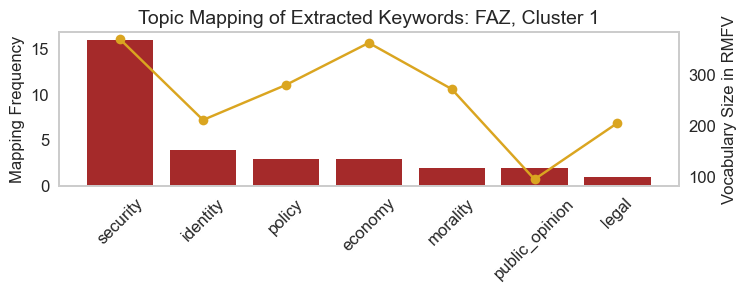

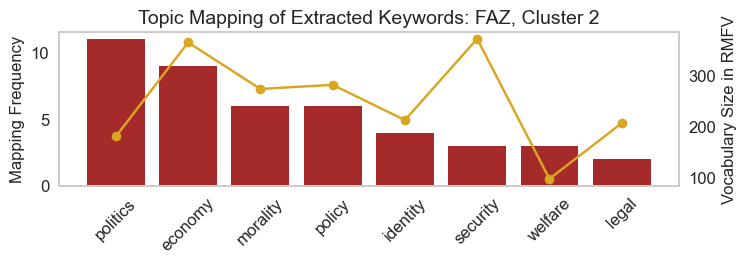

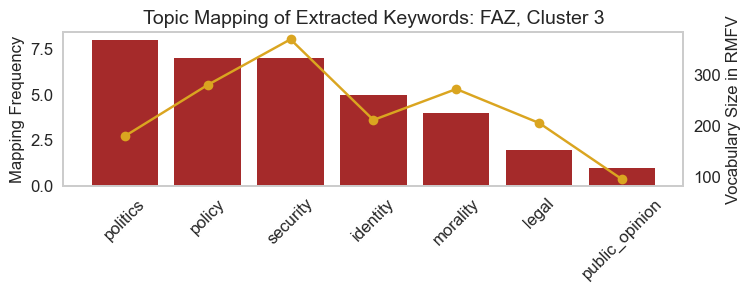

In [38]:
df_mapping_faz = []
all_cluster_labels = []

for i in range(0, 3):
    all_cluster_keywords_faz = [word for item in df_faz_keywords[df_faz_keywords["cluster"] == i]["token"] for word in item]
    df_most_similar_faz = get_rmfv_mapping_of_keywords(word2vec_model_paths["FAZ"], all_cluster_keywords_faz)
    df_mapping_faz.append(df_most_similar_faz)
    all_cluster_labels += [i] * len(all_cluster_keywords_faz)
    plot_rmfv_mapping(df_most_similar_items=df_most_similar_faz, label="FAZ, Cluster " + str(i+1))

In [39]:
df_mapping_faz = pd.concat(df_mapping_faz, ignore_index=True)
df_mapping_faz.insert(1, "cluster", all_cluster_labels)
df_mapping_faz

,cluster_keyword,cluster,most_similar_rmfv_keyword,topic,similarity
0,Hilfe,0,[Hilfe],[morality],1.000000
1,Schlepper,0,[Schlepper],[security],1.000000
2,letzter,0,[Bootsunglück],[security],0.927324
3,Wort,0,[Ausländerfeind],[identity],0.903371
4,Polizist,0,[Polizist],[security],1.000000
...,...,...,...,...,...
95,EU,2,[EU],[policy],1.000000
96,Italien,2,[Mittelmeer],[security],0.921074
97,vorwerfen,2,[Grenzöffnung],[policy],0.979748
98,Asylrecht,2,[Asylrecht],[legal],1.000000


In [40]:
df_mapping_faz.to_csv("./output/rmfv_mapping_faz.tsv", sep="\t", encoding="utf-8", index=False)

## SZ:

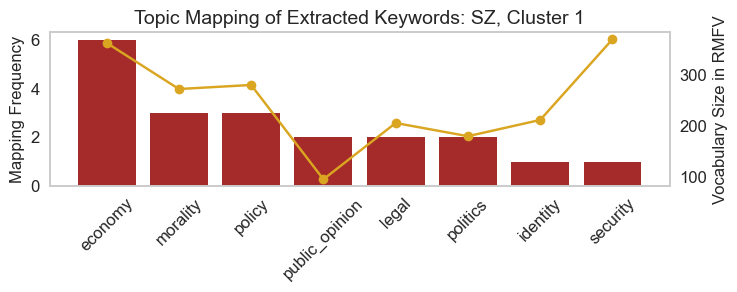

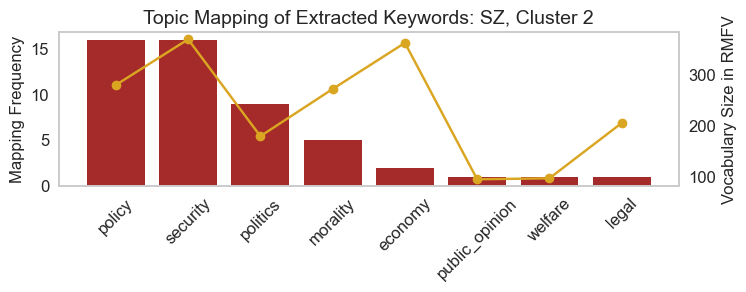

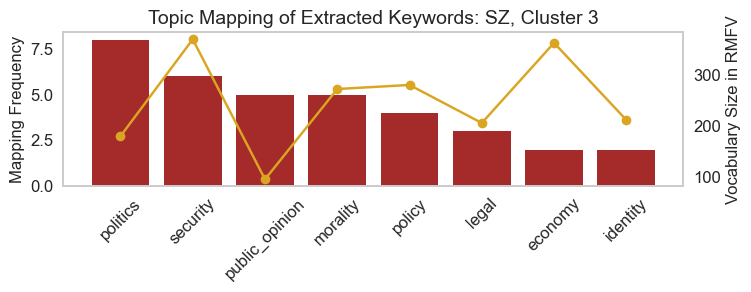

In [41]:
df_mapping_sz = []
all_cluster_labels = []

for i in range(0, 3):
    all_cluster_keywords_sz = [word for item in df_sz_keywords[df_sz_keywords["cluster"] == i]["token"] for word in item]
    df_most_similar_sz = get_rmfv_mapping_of_keywords(word2vec_model_paths["SZ"], all_cluster_keywords_sz)
    df_mapping_sz.append(df_most_similar_sz)
    all_cluster_labels += [i] * len(all_cluster_keywords_sz)
    plot_rmfv_mapping(df_most_similar_items=df_most_similar_sz, label="SZ, Cluster " + str(i+1))

In [42]:
df_mapping_sz = pd.concat(df_mapping_sz, ignore_index=True)
df_mapping_sz.insert(1, "cluster", all_cluster_labels)
df_mapping_sz

,cluster_keyword,cluster,most_similar_rmfv_keyword,topic,similarity
0,Asylbewerber,0,[Euro],[economy],0.936568
1,Problem,0,[Solidarität],[morality],0.981623
2,nennen,0,[äußern],[public_opinion],0.996139
3,Vergangenheit,0,[beherrschen],[policy],0.999201
4,beklagen,0,[Öffentlichkeit],[public_opinion],0.999409
...,...,...,...,...,...
93,Europa,2,[EU],[policy],0.948087
94,Bayern,2,[Straftat],[security],0.989869
95,Bamf,2,[Straftat],[security],0.985557
96,Donnerstag,2,[Bundestag],[politics],0.972781


In [43]:
df_mapping_sz.to_csv("./output/rmfv_mapping_sz.tsv", sep="\t", encoding="utf-8", index=False)